# CS596 Machine Learning 
# Homework Assignment 5 (Part 2): <br>Build a ConvNet Model for Image Classification using TensorFlow

### Due 11:59 pm, Friday, 11/16/2018

**Total credits: 5**

In Part 2 of HA5, you will implement a fully functioning ConvNet model using TensorFlow. You will use the model to conduct image classification on the sign language dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import importlib
importlib.reload(utils)

import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

### Load data

Load the sign language dataset.

(1644, 64, 64, 1)
(1644, 10)
(418, 64, 64, 1)
(418, 10)


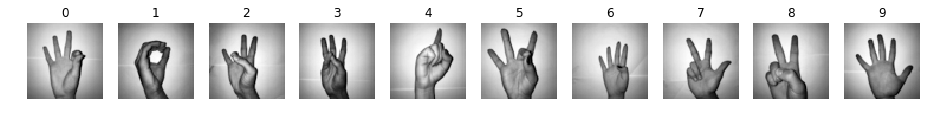

In [2]:
# Load data
X_train, Y_train, X_test, Y_test = utils.load_data()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Visualize some data
fig = plt.figure(figsize=(16, 8))
for i in range(10):
    img = X_train[180*i,:].reshape((64,64))
    fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    y_label = np.argmax(Y_train[180*i,:], axis=0)
    plt.title(y_label)
plt.show()

### Task 2.1 Create placeholders
**0.5 credit**

In TensorFlow you need to create placeholders for the input data. Placeholders are the entry points where data will be fed into the model.

**Instructions:**
- Placeholder X is of shape [None, n_H0, n_W0, n_C0]
- Placeholder Y is of shape [None, n_y]
- For details see the __[docs](https://www.tensorflow.org/api_docs/python/tf/placeholder)__

In [3]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Args:
    n_H0 -- integer, height of an input image
    n_W0 -- integer, width of an input image
    n_C0 -- integer, number of channels of the input
    n_y -- integer, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype tf.float32
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype tf.float32
    """

    ### START TODO ###
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])
    ### END TODO ###
    
    return X, Y

In [4]:
# Evaluate Task 2.1
X, Y = create_placeholders(64, 64, 1, 10)
print ('X =', X)
print ('Y =', Y)

X = Tensor("Placeholder:0", shape=(?, 64, 64, 1), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


### Expected output
*Note*: The placeholder id (the number after the underscore) may be different, but it does not matter as long as dimensions are correct.

|&nbsp;|&nbsp; |          
|--|--|
|**X =**|Tensor("Placeholder_0:0", shape=(?, 64, 64, 1), dtype=float32)|
|**Y =**|Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)|

***

### Task 2.2 Initialize parameters
**0.5 credit**

You will need to initialize two weight parameters (filters) $W_1$ and $W_2$, which are associated with two convolution layers respectively. You don't need to deal with bias parameters, because TensorFlow takes care it for you. 

The dimensions for $W_1$ are [4, 4, 1, 8]. That means for the 1st conv layer, the filter size is $4\times 4\times 1$, and there are 8 of them.

The dimensions for $W_2$ are [2, 2, 8, 16]. That means for the 2nd conv layer, the filter size is $2\times 2\times 8$, and there are 16 of them.

**Instructions:**
- Use the following code to initialize a variable
```python
W = tf.get_variable("W", [dim1, dim2, dim3, dim4], initializer = ...)
```
- Here, the initializer used is `tf.contrib.layers.xavier_initializer(seed = 0)`

In [5]:
def init_params():
    """
    Initializes weight parameters
    The shapes are:
        W1 : [4, 4, 1, 8]
        W2 : [2, 2, 8, 16]
    Returns:
    params -- a Python dict object containing W1, W2
    """
    
    tf.set_random_seed(1)
        
    ### START TODO ### 
    W1 = tf.get_variable("W1",[4,4,1,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    W2 = tf.get_variable("W2",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END TODO ###

    params = {'W1': W1, 'W2': W2}
    
    return params

In [6]:
# Evaluate Task 2.2
tf.reset_default_graph()
with tf.Session() as sess_test:
    params = init_params()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print('W1 =', params['W1'].eval()[1,1,0])
    print('W2 =', params['W2'].eval()[1,1,1])

W1 = [ 0.10352764 -0.03427957  0.18308619  0.15939417  0.17036015 -0.0951044
 -0.13297823 -0.18542323]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**W1 =**|[ 0.10352764 -0.03427957  0.18308619  0.15939417  0.17036015 -0.0951044 <br>-0.13297823 -0.18542323]|
|**W2 =**|[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058 <br>-0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228 <br> -0.22779644 -0.1601823  -0.16117483 -0.10286498]|

***

### Task 2.3 Forward propagation
**2.5 credits**

Use the following functions to implement convolution and pooling layers:
- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')**. X is the input data. The third argument means that using stride = s along 2nd and 3rd axes (i.e., height and width). Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)__.
- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')**. Given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)__.
- **tf.nn.relu(Z1)**. Computes the ReLU activation of Z. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/nn/relu)__.
- **tf.contrib.layers.flatten(P)**. flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)__.
- **tf.contrib.layers.fully_connected(F, num_outputs)**. Given a the flattened input F, it returns the output computed using a fully connected layer. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)__.

The overall model structure is like: <br>
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED.

In [9]:
def forward_propagation(X, params):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Args:
    X -- input dataset placeholder
    parameters -- a Python dict containing 'W1' and 'W2'

    Returns:
    Z3 -- the output from the last fully connected layer
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = params['W1']
    W2 = params['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function.
    # Hint: number of outputs should be 10; one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2,10,activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [10]:
# Evaluate Task 2.3
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 1, 10)
    parameters = init_params()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, feed_dict = {X: np.random.randn(2,64,64,1), Y: np.random.randn(2,10)})
    print('Z3 =', a)
    print('Z3.shape =', a.shape)

Z3 = [[ 0.14326584 -1.2391825   1.1720141   0.39735687  0.5301557  -0.09060775
   0.9489424  -1.2890002   1.093816   -0.71069515]
 [ 0.23505819 -1.2324599   1.4611897   0.3377447   0.88099504 -0.18364665
   1.1464354  -1.1524743   1.0100721  -0.60753226]]
Z3.shape = (2, 10)


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**Z3 =**|[[ 0.14326584 -1.2391825   1.1720141   0.39735687  0.5301557  -0.09060775<br>    0.9489424  -1.2890002   1.093816   -0.71069515]<br>[ 0.23505819 -1.2324599   1.4611897   0.3377447   0.88099504 -0.18364665<br>    1.1464354  -1.1524743   1.0100721  -0.60753226]]|
|**Z3.shape =**|(2, 10)|

***

### Task 2.4
**0.5 credit**

Compute the cost function for softmax. You will need the following two functions:
- **tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y)**. Compute the cross entropy loss, given the output from the fully connected layer Z3, and the ground truth labels Y. We use "\_v2" postfix because the old softmax_cross_entropy_with_logits will be deprecated soon. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)__.
- **tf.reduce_mean**. It computes the mean value of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. Full documentation __[here](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)__.

In [11]:
def compute_cost(Z3, Y):
    """
    Args:
    Z3 -- output of forward propagation 
    Y -- placeholder for ground truth, same shape as Z3
    
    Returns:
    cost - cost function
    """
    
    ### START TODO ### 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END TODO ###
    
    return cost

In [12]:
# Evaluate Task 2.4
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 1, 10)
    params = init_params()
    Z3 = forward_propagation(X, params)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, feed_dict = {X: np.random.randn(4,64,64,1), Y: np.random.randn(4,10)})
    print('cost =', a)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = -2.1021504


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**cost =**|-2.1021502|

***

### Task 2.5 Implement the full model
**1 credit**

Now you will use the functions you have implemented above to build a full model. Then you train the model on the sign language dataset.

**Instructions:**
- Call `create_placeholders()`, `init_params()`, `forward_propagation()` and `compute_cost()` sequencially
- Then we define an Adam `optimizer` to minimize the cost returned by `compute_cost`
- You will use two `for` loops for training. The outer loop is to iterate over epochs, and the inner loop is to iterate over the minibatches in the current epoch. Note that for each epoch, the generated minibatch data are different. If you are interested how minibatches are generated, check out the `generate_minibatch` function in utils.py
- For each step of the inner loop, you run the session by calling `sess.run(...)`. In its arguments, you need to specify which variables you want to run (in our case, it is `cost` and `optimizer`), and you also need to feed the minibatch data (minibatch_X, minibatch_Y) to the placeholders (X, Y) respectively (using the argument `feed_dict`). For details, see the previous two evaluation cells for reference, and you can also check the documentation __[here](https://www.tensorflow.org/api_docs/python/tf/Session)__

In [21]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Args:
    X_train -- training set, of shape (None, 64, 64, 1)
    Y_train -- test set, of shape (None, 10)
    X_test -- training set, of shape (None, 64, 64, 1)
    Y_test -- test set, of shape (None, 10)
    learning_rate -- learning rate 
    num_epochs -- number of epochs
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_acc -- accuracy on the train set (X_train)
    test_acc -- testing accuracy on the test set (X_test)
    params -- parameters learnt by the model
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    ### START TODO ###
    # Create Placeholders of the correct shape. Call create_placeholders()
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters. Call init_params()
    params = init_params()
    
    # Forward propagation. Call forward_propagation()
    Z3 = forward_propagation(X, params)
    
    # Cost function. Call compute_cost()
    cost = compute_cost(Z3, Y)
    ### END TODO ###
    
    # Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = utils.generate_minibatch(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                ### START TODO ### 
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for placeholders (X,Y).
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                ### END TODO ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        acc = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print(acc)
        train_acc = acc.eval({X: X_train, Y: Y_train})
        test_acc = acc.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
                
        return train_acc, test_acc, params

Cost after epoch 0: 2.406659
Cost after epoch 5: 0.947872
Cost after epoch 10: 0.518344
Cost after epoch 15: 0.382350
Cost after epoch 20: 0.302683
Cost after epoch 25: 0.235840
Cost after epoch 30: 0.211325
Cost after epoch 35: 0.219005
Cost after epoch 40: 0.149102
Cost after epoch 45: 0.138424
Cost after epoch 50: 0.137292
Cost after epoch 55: 0.120805
Cost after epoch 60: 0.090409
Cost after epoch 65: 0.095341
Cost after epoch 70: 0.065797
Cost after epoch 75: 0.070322
Cost after epoch 80: 0.075480
Cost after epoch 85: 0.046717
Cost after epoch 90: 0.065762
Cost after epoch 95: 0.044523


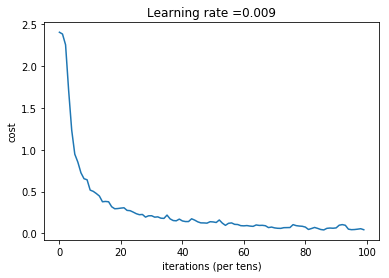

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.98540145
Test Accuracy: 0.87081337


In [22]:
# Evaluate Task 2.5
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

# Note: it could be slow to run 100 epochs. Make sure that your costs for after epoch 0 and epoch 5 
# are the same as those in the expected output. If yours are different, click the stop button (black square)
# on the menu bar and check your code.

### Expected output

|&nbsp;|&nbsp; |
|--|--|
|**Cost after epoch 0:**|2.406659|
|**Cost after epoch 5:**|1.093442|
|...|...|
|**Train Accuracy:**|0.98965937|
|**Test Accuracy:**|0.8732057|

***

### Congratulations!
Now you have successfully built a convolutional neural network model for image classification! Hopefully this experience of using TensorFlow will help you with your term project.